In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

In [7]:
import tensorflow as tf
print(f'tensorflow version {tf.__version__}')

tensorflow version 2.4.0


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [9]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

In [12]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.74,686.0,245.0,220.50,3.5,2,0.25,4,12.32,14.92
1,0.74,686.0,245.0,220.50,3.5,3,0.10,1,10.43,13.71
2,0.69,735.0,294.0,220.50,3.5,3,0.40,5,14.28,15.87
3,0.79,637.0,343.0,147.00,7.0,5,0.10,2,36.03,42.86
4,0.98,514.5,294.0,110.25,7.0,4,0.40,4,32.21,33.95


In [13]:
# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [15]:
norm_train_X.head()

,X1,X2,X3,X4,X5,X6,X7,X8
362,-0.007873,-0.147841,2.235426,-1.226086,1.015593,0.425453,-1.032303,1.417343
409,2.077460,-1.813421,-0.585272,-1.498846,1.015593,1.317016,-1.032303,-1.172682
603,0.940006,-0.980631,-0.585272,-0.680567,1.015593,1.317016,-1.032303,-0.525176
474,0.560854,-0.703034,-0.021132,-0.680567,1.015593,1.317016,-1.032303,1.417343
26,-0.007873,-0.147841,2.235426,-1.226086,1.015593,-1.357674,1.251784,1.417343


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 128)          1152        input_7[0][0]                    
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 128)          16512       dense_18[0][0]                   
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 64)           8256        dense_19[0][0]                   
____________________________________________________________________________________________

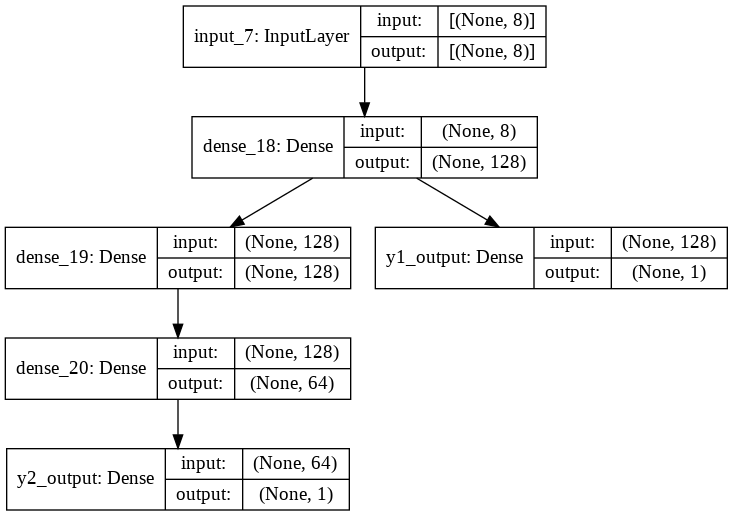

In [25]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model

input = Input(shape=(len(train.columns, )))

first_dense = Dense(128, activation='relu')(input)
second_dense = Dense(128, activation='relu')(first_dense)

y1_output = Dense(1, name='y1_output')(first_dense)

third_dense = Dense(64, activation='relu')(second_dense)
y2_output = Dense(1, name='y2_output')(third_dense)

model = Model(inputs=input, outputs=[y1_output, y2_output])
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [28]:
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(), 
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

In [29]:
history = model.fit(norm_train_X, train_Y, epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 6ms/step - loss: 736.3899 - y1_output_loss: 398.4540 - y2_output_loss: 337.9359 - y1_output_root_mean_squared_error: 19.6422 - y2_output_root_mean_squared_error: 17.5852 - val_loss: 64.4597 - val_y1_output_loss: 28.5524 - val_y2_output_loss: 35.9074 - val_y1_output_root_mean_squared_error: 5.3434 - val_y2_output_root_mean_squared_error: 5.9923
Epoch 2/500
62/62 [==============================] - 0s 5ms/step - loss: 54.3067 - y1_output_loss: 25.7527 - y2_output_loss: 28.5540 - y1_output_root_mean_squared_error: 5.0573 - y2_output_root_mean_squared_error: 5.3204 - val_loss: 80.9124 - val_y1_output_loss: 13.1555 - val_y2_output_loss: 67.7570 - val_y1_output_root_mean_squared_error: 3.6270 - val_y2_output_root_mean_squared_error: 8.2315
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 36.4234 - y1_output_loss: 15.3246 - y2_output_loss: 21.0987 - y1_output_root_mean_squared_error: 3.9091 - y2_output_root_mean_sq

5/5 [==============================] - 0s 2ms/step - loss: 1.3032 - y1_output_loss: 0.2545 - y2_output_loss: 1.0488 - y1_output_root_mean_squared_error: 0.5044 - y2_output_root_mean_squared_error: 1.0241
Loss = 1.3032325506210327, Y1_loss = 0.25446584820747375, Y1_mse = 0.5044460892677307, Y2_loss = 1.0487667322158813, Y2_mse = 1.0240931510925293


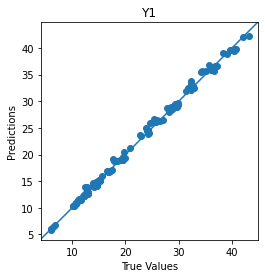

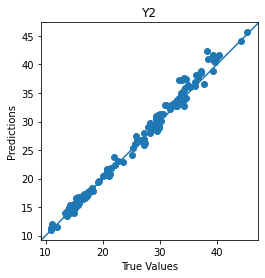

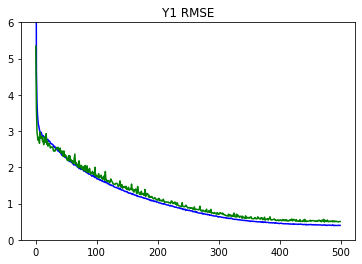

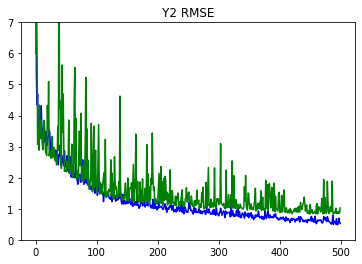

In [33]:
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(norm_test_X, test_Y)
print(f"Loss = {loss}, Y1_loss = {Y1_loss}, Y1_mse = {Y1_rmse}, Y2_loss = {Y2_loss}, Y2_mse = {Y2_rmse}")
Y_pred = model.predict(norm_test_X)

plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)